In [1]:
import pandas as pd
import pickle
from geopy.distance import great_circle
import operator
from scipy import sparse
from scipy.sparse import csr_matrix, vstack, hstack, coo_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline

In [2]:
b = pd.read_json("../../../../../yelp-dataset/yelp_academic_dataset_business.json", lines=True)
b = b[(b.state == "NV")]

In [3]:
((b.isnull().sum()/len(b)) * 100).round(5)

address          0.00000
attributes      14.41101
business_id      0.00000
categories       0.28581
city             0.00000
hours           22.38287
is_open          0.00000
latitude         0.00280
longitude        0.00280
name             0.00000
neighborhood     0.00000
postal_code      0.00000
review_count     0.00000
stars            0.00000
state            0.00000
dtype: float64

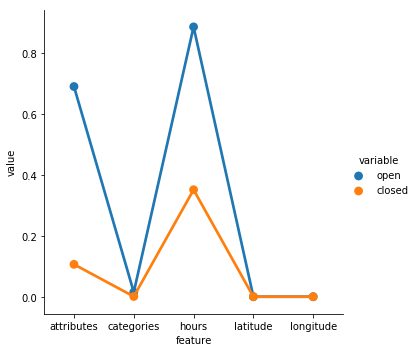

In [4]:
nulls_count = pd.DataFrame({"open":(b[b.is_open == True].isnull().sum()/len(b[b.is_open == False])).round(5), 
                           "closed":(b[b.is_open == False].isnull().sum()/len(b[b.is_open == False])).round(5)})

nulls_count = nulls_count[(nulls_count.open > 0) | (nulls_count.closed > 0)]
nulls_count["feature"] = nulls_count.index
nulls_count_melted = pd.melt(nulls_count, id_vars=['feature'], value_vars=['open', 'closed'])
sns.catplot(x="feature", y="value", hue="variable", kind="point", data=nulls_count_melted)
sns.despine()
plt.show()

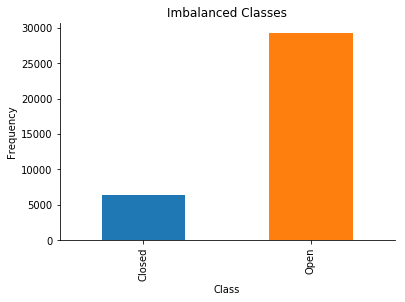

In [5]:
count_classes = pd.value_counts(b.is_open, sort=True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Imbalanced Classes")
plt.xticks([0,1], ("Closed", "Open"))
plt.xlabel("Class")
plt.ylabel("Frequency")
sns.despine()
plt.show()

In [6]:
b.drop("hours", axis=1, inplace=True)
b = b.drop(b[b.categories.isnull()].index)
b = b.drop(b[(b.latitude.isnull()) | (b.longitude.isnull()) ].index)
b = b.drop("attributes", axis=1)
# nulls in percent
((b.isnull().sum()/len(b)) * 100).round(5)

address         0.0
business_id     0.0
categories      0.0
city            0.0
is_open         0.0
latitude        0.0
longitude       0.0
name            0.0
neighborhood    0.0
postal_code     0.0
review_count    0.0
stars           0.0
state           0.0
dtype: float64

### Binarize Categories

In [7]:
b.categories.head()

1     Chicken Wings, Burgers, Caterers, Street Vendo...
17                 Shopping, Fashion, Department Stores
18    Financial Services, Check Cashing/Pay-day Loan...
19    American (Traditional), Food, Bakeries, Restau...
20    Home Services, Masonry/Concrete, Professional ...
Name: categories, dtype: object

In [8]:
b.loc[:, 'categories'] = b.categories.str.replace("Books, Mags, Music & Video", "Books+Mags+ & MusicVideo")
b.loc[:, 'categories'] = b.categories.str.replace("Used, Vintage & Consignment", "Used+Vintage+ & Consignment")
b.loc[:, 'categories'] = b.categories.str.replace("Beer, Wine & Spirits", "Beer+Wine & Spirits")
b.loc[:, 'categories'] = b.categories.str.replace("Wills, Trusts, & Probates", "Wills+Trusts+&Probates")

# split by comma
categories_series = b.categories.apply(lambda x: x.split(","))
# a  lambda function to convert the following data structure
# [list(['Tours', ' Breweries', ' Pizza', ' Restaurants', ' Food', ' Hotels & Travel'])
# to 
# ['Tours', ' Breweries', ' Pizza', ' Restaurants', ' Food', ' Hotels & Travel']
take_out_list = lambda x: list(x)
# get 2D list
categories_2D_list = take_out_list(categories_series)
# remove leading and trailing white spaces
for alist in categories_2D_list:
    alist[:] = [category.strip() for category in alist]
#print(categories_2D_list[:3])
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
categories_binarized = mlb.fit_transform(categories_2D_list)
#print(categories_binarized.shape)
#print(mlb.classes_.shape)
# mlb.classes_ returns the unique categories found by the binarizer
categories_binarized_df = pd.DataFrame(categories_binarized, columns=list(mlb.classes_))
categories_binarized_df.sample(5)

,3D Printing,ATV Rentals/Tours,Acai Bowls,Accessories,Accountants,Acne Treatment,Active Life,Acupuncture,Addiction Medicine,Adult,...,Wine Tasting Room,Wine Tours,Wineries,Women's Clothing,Workers Compensation Law,Wraps,Yelp Events,Yoga,Ziplining,Zoos
7544,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28105,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5787,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4774,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21682,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


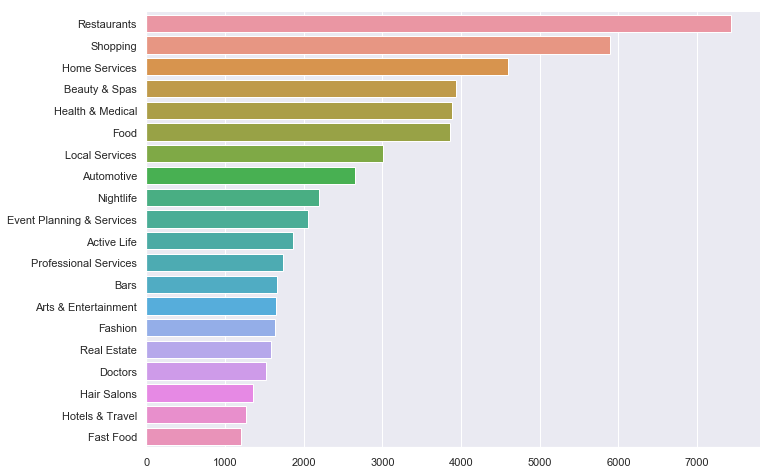

In [9]:
top_20_categories = categories_binarized_df.sum().sort_values(ascending=False)[:20]
sns.set(rc={'figure.figsize':(11,8)})
ax = sns.barplot(y=top_20_categories.index, x=top_20_categories.values, orient='h')
sns.despine()

Are these categories combined in groups of 3 or more?

In [10]:
# find the number of total busineses
total_business = categories_binarized_df.shape[0]

combinations_of_top20 = categories_binarized_df[top_20_categories.index].apply(lambda x: list(x.index[np.where(x != 0)]), axis=1)

value_counts_top20 = combinations_of_top20.value_counts()

# convert index to string to make it hashable
import json
# dumps converts list to string
value_counts_top20.index = value_counts_top20.index.map(json.dumps)
count_g_2 = 0
for c in value_counts_top20.index:
    # count combinations of two or more categories
    # loads converts back to list
    if(len(json.loads(c)) > 2):
        count_g_2 += value_counts_top20.loc[c]
print(count_g_2)
print(np.round((count_g_2/total_business) * 100, 2), "%")

3894
10.94 %


Only 10% of all businesses have combined categories from the top-20 categories

In [11]:
total_business

35584

Which business is popular and has the highest closure rate

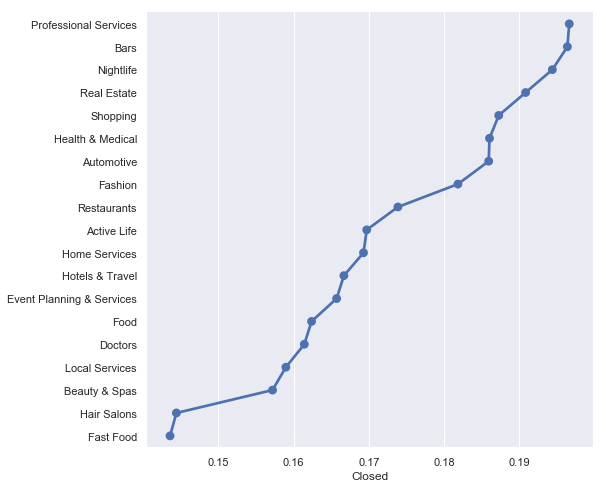

In [12]:
# concatenate is_open info to the binaried categories data
open_close_df = pd.concat([categories_binarized_df[top_20_categories.index], b.is_open], axis=1)
# find all open businesses
open_df = open_close_df[open_close_df.is_open ==1]
# find all closed businesses
close_df = open_close_df[open_close_df.is_open ==0]
# sum across columns to find number of open business in each column(category)
open_close_count = (pd.concat([open_df.sum(), close_df.sum()], axis=1))
# change the default column names
open_close_count.columns = ["Open", "Closed"]
#print(open_close_count)
# divide the counts by the total businesses in each category
open_close_count_normalized = open_close_count.div(open_df.sum() + close_df.sum(), axis=0).sort_values(by="Closed", ascending=False)[:-2]
sns.set(rc={'figure.figsize':(8,8)})
ax = sns.pointplot(x=open_close_count_normalized.Closed, y=open_close_count_normalized.index, orient='h')
sns.despine()

### Reviews By Year

In [13]:
# # takes 15 minutes
# review_reader = pd.read_json("../../../../../yelp-dataset/yelp_academic_dataset_review.json", lines=True, chunksize=csize)
# total_reviews = 0 
# restaurant_open_review_years = []
# restaurant_closed_review_years = []
# shopping_open_review_years = []
# shopping_closed_review_years = []

# for i, r in enumerate(review_reader):
#     total_reviews += r.shape[0]
#     print("working on chunk ",i," shape =", r.shape[0])
    
#     restaurant_reviewsR = pd.merge(restaurants_df, r, on=["business_id"])
    
#     restaurant_reviews_closed = restaurant_reviewsR[restaurant_reviewsR.is_open == 0]
#     restaurant_reviews_open = restaurant_reviewsR[restaurant_reviewsR.is_open == 1]
    
#     restaurant_closed_review_years.append(pd.to_datetime(restaurant_reviews_closed.date.dt.year).values)
#     restaurant_open_review_years.append(pd.to_datetime(restaurant_reviews_open.date.dt.year).values)
 
#     shopping_restaurantR= pd.merge(shopping_df, r, on=["business_id"])
    
#     shopping_reviews_closed = shopping_restaurantR[shopping_restaurantR.is_open == 0]
#     shopping_reviews_open = shopping_restaurantR[shopping_restaurantR.is_open == 1]
    
#     shopping_closed_review_years.append(pd.to_datetime(shopping_reviews_closed.date.dt.year).values)
#     shopping_open_review_years.append(pd.to_datetime(shopping_reviews_open.date.dt.year).values)
    
# # save the lists to file
# pickle.dump(restaurant_open_review_years, open("../../../../../yelp-dataset/restaurant_open_review_years_Nevada.sav", 'wb'))
# pickle.dump(restaurant_closed_review_years, open("../../../../../yelp-dataset/restaurant_closed_review_years_Nevada.sav", 'wb'))
# pickle.dump(shopping_open_review_years, open("../../../../../yelp-dataset/shopping_open_review_years_Nevada.sav",'wb'))
# pickle.dump(shopping_closed_review_years, open("../../../../../yelp-dataset/shopping_closed_review_years_Nevada.sav", 'wb'))

In [14]:
# # load lists from file
restaurant_open_review_years = pickle.load(open("../../../../../yelp-dataset/restaurant_open_review_years_Nevada.sav", 'rb'))
restaurant_closed_review_years = pickle.load(open("../../../../../yelp-dataset/restaurant_closed_review_years_Nevada.sav", 'rb'))
shopping_open_review_years = pickle.load(open("../../../../../yelp-dataset/shopping_open_review_years_Nevada.sav", 'rb'))
shopping_closed_review_years = pickle.load(open("../../../../../yelp-dataset/shopping_closed_review_years_Nevada.sav", 'rb'))

restaurant_open_review_years = np.concatenate(restaurant_open_review_years).ravel()
restaurant_closed_review_years = np.concatenate(restaurant_closed_review_years).ravel()
shopping_open_review_years = np.concatenate(shopping_open_review_years).ravel()
shopping_closed_review_years = np.concatenate(shopping_closed_review_years).ravel()

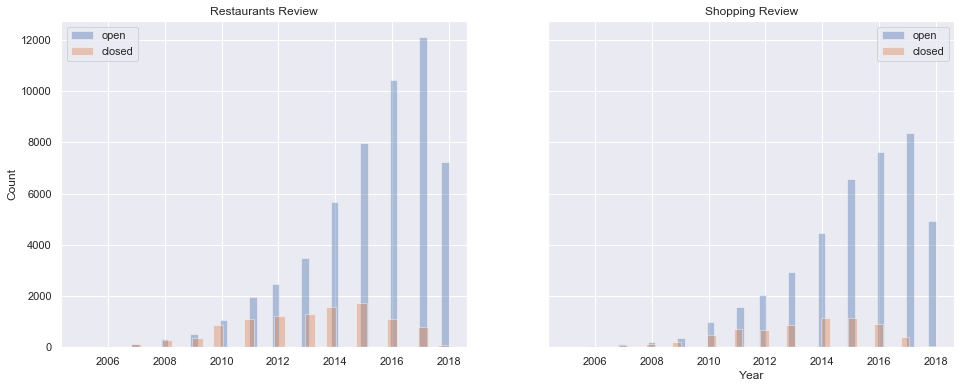

In [15]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,6), sharey=True)

sns.set(rc={'figure.figsize':(4,4)})
sns.distplot(restaurant_open_review_years.astype(int), kde=False, label="open", ax=ax1)
sns.distplot(restaurant_closed_review_years.astype(int), kde=False, label = "closed", ax=ax1)
ax1.legend()
ax1.set_ylabel("Count")
ax2.set_xlabel("Year")
ax1.set_title("Restaurants Review")

sns.distplot(shopping_open_review_years.astype(int), kde=False, label="open", ax=ax2)
sns.distplot(shopping_closed_review_years.astype(int), kde=False, label = "closed", ax=ax2)
ax2.set_title("Shopping Review")
ax2.set_xlabel("Year")
ax1.set_ylabel("Count")

ax2.legend()
plt.show()

### Restaurant Businesses

In [16]:
restaurants_filter = pd.DataFrame({"Restaurants":categories_binarized_df.Restaurants.tolist(), 
                                 "business_id":b.business_id.tolist(),
                                  "is_open":b.is_open.tolist(),
                                  "latitude": b.latitude,
                                  "longitude":b.longitude,
                                  "stars":b.stars,
                                  "review_count":b.review_count})

restaurants_only = restaurants_filter[restaurants_filter.Restaurants == 1].drop("Restaurants", axis=1)

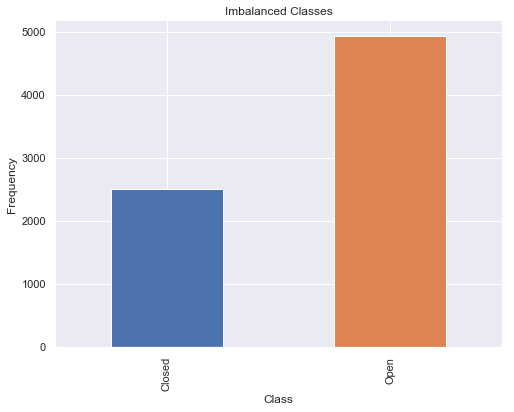

In [17]:
sns.set(rc={'figure.figsize':(8,6)})
count_classes = pd.value_counts(restaurants_only.is_open, sort=True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Imbalanced Classes")
plt.xticks([0,1], ("Closed", "Open"))
plt.xlabel("Class")
plt.ylabel("Frequency")
sns.despine()
plt.show()

### Train/Test Split

In [18]:
X = restaurants_only.drop("is_open", axis=1)
# # change is_open to is_closed
y = np.where(restaurants_only["is_open"] == 0 , 1, 0)
# stratified sampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20, shuffle=True, stratify=y)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
# combine x and y to ease feature engineering
# shallow copy
train = X_train.copy(deep=True)
train["is_closed"] = y_train
test = X_test.copy(deep=True)
# shallow copy
test["is_closed"] = y_test
print(train.shape)
train.head()

(5944, 6)


,business_id,latitude,longitude,stars,review_count,is_closed
0,SZD6OTT1cc-ZznfAoyKudw,36.202864,-115.198951,2.5,76,0
1,WxBclAFq06uQsh0RsIaw6g,36.060455,-115.041089,3.5,30,0
2,VFVyecs0nMFA4xizXkzvKA,36.100457,-115.304218,3.0,22,1
3,znDUBjt-m2qmXi_p3m3rDA,36.115307,-115.132793,2.0,45,1
4,8rEpnbz_WyYl9VpCweeekQ,36.240568,-115.116433,4.5,106,0


### Distance Features
Within 1 mile circle, average ratings, average number of reviews

In [19]:
# A vectorized implemenation of geopy.distance.great_circle function
# Adopted by Tinsae 
# reference
# https://gist.github.com/rochacbruno/2883505
    
import math
# calculate the disance between a business and all other businesses
def distance_c(many_points, one_point):
    # convert the values to float
    lat1 = many_points[:,0].astype(float) 
    lon1 = many_points[:,1].astype(float)
    lat2 = one_point[0]
    lon2 = one_point[1]
    #radius = 6371 # km
    radius = 3959 # miles
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    a = np.sin(dlat/2) * np.sin(dlat/2) + np.cos(np.radians(lat1)) \
        * np.cos(np.radians(lat2)) * np.sin(dlon/2) * np.sin(dlon/2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = radius * c

    return d

# for testing purposes(calculating the distance between buisness@1 and others)
business5 = train[['latitude', 'longitude']].values[5:6]
business8 = train[['latitude', 'longitude']].values[8:9]
business18 = train[['latitude', 'longitude']].values[18:19]
business1 = train[['latitude', 'longitude']].values[1]

print("distance from 5: ", great_circle(business5, business1).miles)
print("distance from 8: ", great_circle(business8, business1).miles)
print("distance from 18: ", great_circle(business18, business1).miles)

distance_c(train[['latitude', 'longitude']].values[0:20], business1)     

distance from 5:  6.2450271911948665
distance from 8:  12.258590992994463
distance from 18:  7.080313021869732


array([13.20764169,  0.        , 14.95186921,  6.37071265, 13.13613643,
        6.2454035 , 13.75084072, 20.68395675, 12.25932966, 16.06467297,
       10.64581306, 14.58945972, 12.87222072,  5.72052756, 20.9879651 ,
       11.9333617 ,  8.35707063, 13.58094513,  7.08073966,  5.49424581])

In [20]:
import time

nearest_average_rating = []
nearest_average_num_of_reviews =  []
start_time = time.time()
def create_distance_features(current):
    # find the distance between current row and all other rows using the vectorized function
    the_distances = distance_c(train[['latitude', 'longitude']].values, (current.latitude, current.longitude))    
    # A distance cannot be negative. 0 indicates it is the same place
    # so both shall be excluded
    indices_to_select = np.where((the_distances < 1) & (the_distances > 0))[0]
    # if a business within one mile is found
    if(len(indices_to_select) > 0):
        nearest_average_rating.append(train.iloc[indices_to_select, :].stars.mean())
        nearest_average_num_of_reviews.append(train.iloc[indices_to_select, :].review_count.mean())
    else:
        nearest_average_rating.append("No-Nearest")
        nearest_average_num_of_reviews.append("No-Nearest")

        
train.apply(lambda x: create_distance_features(x), axis=1)
print(time.time() - start_time, " seconds")


train["nearest_average_rating"] = pd.Series(nearest_average_rating)
train["nearest_average_num_of_reviews"] = pd.Series(nearest_average_num_of_reviews)
train.to_csv("train.csv")
train.head()

13.080368757247925  seconds


,business_id,latitude,longitude,stars,review_count,is_closed,nearest_average_rating,nearest_average_num_of_reviews
0,SZD6OTT1cc-ZznfAoyKudw,36.202864,-115.198951,2.5,76,0,3.20833,40.8333
1,WxBclAFq06uQsh0RsIaw6g,36.060455,-115.041089,3.5,30,0,3.29508,122.779
2,VFVyecs0nMFA4xizXkzvKA,36.100457,-115.304218,3.0,22,1,3.66129,140.282
3,znDUBjt-m2qmXi_p3m3rDA,36.115307,-115.132793,2.0,45,1,3.50282,99.0339
4,8rEpnbz_WyYl9VpCweeekQ,36.240568,-115.116433,4.5,106,0,3.28333,63.1667


In [21]:
# some restaurants may not have other restaurantants within 1 mile distance
train[train.nearest_average_rating == "No-Nearest"].shape[0]

28

In [22]:
train = train.drop(train[train.nearest_average_rating == "No-Nearest"].index)
train.shape

(5916, 8)

### Bag of Words

In [23]:
train.head()

,business_id,latitude,longitude,stars,review_count,is_closed,nearest_average_rating,nearest_average_num_of_reviews
0,SZD6OTT1cc-ZznfAoyKudw,36.202864,-115.198951,2.5,76,0,3.20833,40.8333
1,WxBclAFq06uQsh0RsIaw6g,36.060455,-115.041089,3.5,30,0,3.29508,122.779
2,VFVyecs0nMFA4xizXkzvKA,36.100457,-115.304218,3.0,22,1,3.66129,140.282
3,znDUBjt-m2qmXi_p3m3rDA,36.115307,-115.132793,2.0,45,1,3.50282,99.0339
4,8rEpnbz_WyYl9VpCweeekQ,36.240568,-115.116433,4.5,106,0,3.28333,63.1667


In [24]:
# #Takes a lot of time
# import time
# from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
# start_time = time.time()
# review_reader = pd.read_json("../../../../../yelp-dataset/yelp_academic_dataset_review.json", lines=True, chunksize=csize)
# from scipy import sparse
# for i, r in enumerate(review_reader):
#     print("working on chunk ",i," shape =", r.shape[0])
#     train_reviews = pd.merge(train, r, on=["business_id"])
#     # save dense matrix to file
#     train_reviews.to_csv("../../../../../yelp-dataset/train_reviews_Nevada"+ str(i) + ".csv")
#     # tokens containing numbers, digits and underscore are ignored
    
#     train_vectorizer = CountVectorizer(stop_words='english', min_df=0.01) 
#     # remove punctuation and numbers
#     train_reviews.text = train_reviews.text.str.replace(r'[^\w\s]+|[\d]+', '')
#     train_tf_idf_features = train_vectorizer.fit_transform(train_reviews.text)
#     # save vectorizer
#     pickle.dump(train_vectorizer, open("../../../../../yelp-dataset/train_vectorizer_Nevada"+ str(i) +".sav", 'wb'))
#     # save sparse matrix to file
#     sparse.save_npz("../../../../../yelp-dataset/train_tf_idf_features_Nevada"+ str(i) + ".npz", train_tf_idf_features)
#     print("shape of dense matrix: ", train_reviews.shape)
#     print("shape of sparse matrix: ", train_tf_idf_features.shape)
# print(time.time() - start_time)

Let us see the number of business that have atleast one review in the Chunks

In [25]:
from scipy import sparse
import pickle
import operator

for i in range(6):
    #sparse = sparse.load_npz("../../../../../yelp-dataset/tf_idf_features" + i + ".npz")
    #vectorizer = pickle.load(open("../../../../../yelp-dataset/vectorizer"+ i + ".sav", 'rb'))
    dense = pd.read_csv("../../../../../yelp-dataset/train_reviews_Nevada" + str(i) + ".csv", index_col=0)
    #word_headers = np.array(sorted(vectorizer.vocabulary_.items(), key=operator.itemgetter(1)))[:,0]
    num_of_businesses = len(dense.business_id.groupby(dense.business_id).groups.items())
    print("chunk ", i, " number of businesses: ", num_of_businesses)

chunk  0  number of businesses:  5191
chunk  1  number of businesses:  5429
chunk  2  number of businesses:  5423


C:\Users\Tinsae\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (0,2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


chunk  3  number of businesses:  5433
chunk  4  number of businesses:  5509
chunk  5  number of businesses:  5463


In [26]:
# using chunk2(train)
i = 2
sparse_train = sparse.load_npz("../../../../../yelp-dataset/train_tf_idf_features_Nevada" + str(i) + ".npz")
train_vectorizer = pickle.load(open("../../../../../yelp-dataset/train_vectorizer_Nevada"+ str(i) + ".sav", 'rb'))
dense_train = pd.read_csv("../../../../../yelp-dataset/train_reviews_Nevada" + str(i) + ".csv", index_col=0)
# these are the >700 word features in the sparse matrix order(alphabetical)
word_headers_train = np.array(sorted(train_vectorizer.vocabulary_.items(), key=operator.itemgetter(1)))[:,0]
# get the indices of reviews for each business id
dense_dict_train = dense_train.business_id.groupby(dense_train.business_id).groups
print("Showing 6 businesses from ", len(dense_train.keys()))
for i, item in enumerate(dense_dict_train.items()):
    if(i > 5):
        break;
    print(item)
print(sparse_train.shape)
print(dense_train.shape)

Showing 6 businesses from  16
('--9e1ONYQuAa-CB_Rrw7Tw', Int64Index([40941, 40942, 40943, 40944, 40945, 40946, 40947, 40948, 40949,
            40950,
            ...
            41181, 41182, 41183, 41184, 41185, 41186, 41187, 41188, 41189,
            41190],
           dtype='int64', length=250))
('--q7kSBRb0vWC8lSkXFByA', Int64Index([107339], dtype='int64'))
('-153AjTW5luZPK4omEujWA', Int64Index([58467], dtype='int64'))
('-1m9o3vGRA8IBPNvNqKLmA', Int64Index([113439, 113440, 113441, 113442, 113443, 113444, 113445, 113446,
            113447, 113448, 113449, 113450, 113451, 113452, 113453, 113454,
            113455, 113456, 113457, 113458, 113459, 113460, 113461, 113462,
            113463, 113464, 113465, 113466, 113467, 113468, 113469, 113470,
            113471, 113472, 113473],
           dtype='int64'))
('-3zffZUHoY8bQjGfPSoBKQ', Int64Index([157802, 157803, 157804, 157805, 157806, 157807, 157808, 157809,
            157810, 157811, 157812, 157813, 157814, 157815, 157816, 157817

### Outlier Detection

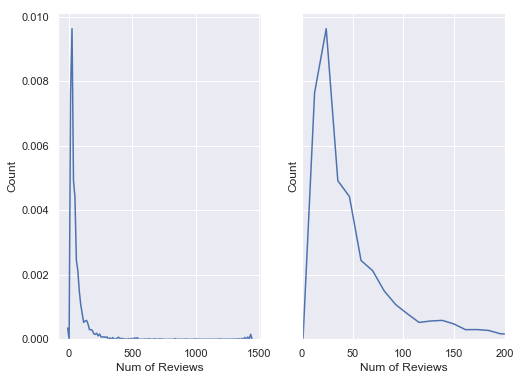

In [27]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,6), sharey=True)
# making spaces between subplots
#fig.subplots_adjust(hspace = 0.2, wspace = 0.2)
count_list = [len(value) for value in dense_dict_train.values()]
ax1.set_xlabel("Num of Reviews")
ax2.set_xlabel("Num of Reviews")
ax1.set_ylabel("Count")
ax2.set_ylabel("Count")
sns.kdeplot(count_list, ax=ax1)
sns.kdeplot(count_list, ax=ax2)
ax2.set_xlim(0, 200)
plt.show()

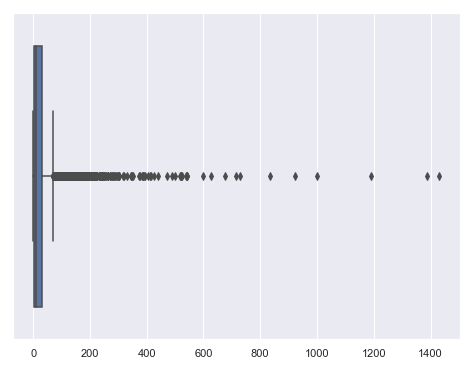

In [28]:
count_list = [len(value) for value in dense_dict_train.values()]
sns.boxplot(count_list)
plt.show()

In [29]:
count_list = [len(value) for value in dense_dict_train.values()]
print("Highly reviewed businesses at", np.where(np.array(count_list) > 1000))
print()
for ind in np.where(np.array(count_list) > 600)[0]:
    busi1 = list(dense_dict_train.items())[ind][0]
    print("name", "state", "review_count", "address")
    print((b[b.business_id == busi1][["name", "state", "review_count", "address"]]).values.ravel())


Highly reviewed businesses at (array([ 433, 1761, 2368], dtype=int64),)

name state review_count address
['Mon Ami Gabi' 'NV' 7968 '3655 Las Vegas Blvd S']
name state review_count address
['Earl of Sandwich' 'NV' 4981 '3667 Las Vegas Blvd S']
name state review_count address
['MGM Grand Hotel' 'NV' 3730 '3799 Las Vegas Blvd S']
name state review_count address
['Wicked Spoon' 'NV' 6446 '3708 Las Vegas Blvd S']
name state review_count address
['Lotus of Siam' 'NV' 3975 '953 E Sahara Ave']
name state review_count address
['Bacchanal Buffet' 'NV' 7866 '3570 S Las Vegas Blvd']
name state review_count address
['Gordon Ramsay BurGR' 'NV' 5472 '3667 Las Vegas Blvd S']
name state review_count address
['Hash House A Go Go' 'NV' 5382 '3535 Las Vegas Blvd']
name state review_count address
['Secret Pizza' 'NV' 4078 '3708 Las Vegas Blvd S']
name state review_count address
['The Buffet at Bellagio' 'NV' 4091 '3600 S Las Vegas Blvd']


### Word Counts Per Business

In [30]:
len(list(dense_dict_train.items()))

5423

In [31]:
# # for nevada
# import time
# def create_aggregate_sparse_matrix(the_dictionary, dict_number):
#     #takes 10 minutes
#     start_time = time.time()
#     train_vectorizer = pickle.load(open("../../../../../yelp-dataset/train_vectorizer_Nevada2.sav", 'rb'))
#     num_of_sparse_features = len(train_vectorizer.vocabulary_)
#     # initial coo matrix-all zeros
#     the_matrix = coo_matrix(np.array([0] * num_of_sparse_features ))
#     # k goes over the business ids
#     # i counts
#     for i, k in enumerate(the_dictionary.keys()):
#         if( i % 1000 == 0):
#             print("creating row: ", i)
#         # convert to list: row indices for the reviews of k
#         indices_for_sparse_matrix = list(the_dictionary[k])
#         #print(indices_for_sparse_matrix)
#         #print(k)
#         # find means column-wise
#         means_sparse = sparse_train[indices_for_sparse_matrix, :].mean(axis=0).tolist()[0]
#         # append new row to the sparse matrix
#         the_matrix = vstack((the_matrix, means_sparse))
#     print(time.time() - start_time)
#     # convert to csr matrix and remove the first row
#     the_matrix = the_matrix.tocsr()[1:]
#     # save aggregate sparse matrix
#     sparse.save_npz("../../../../../yelp-dataset/aggregate_sparse_matrix_train_Nevada" + str(dict_number) + ".npz", the_matrix)
    
# create_aggregate_sparse_matrix(dense_dict_train, 0)

### Bag of Words + Dense Features

In [32]:
#load sparse matrices  # I added 0 by mistake
aggregate_sparse_matrix_train = sparse.load_npz("../../../../../yelp-dataset/aggregate_sparse_matrix_train_Nevada0.npz")

# calculate sparsity
print("Sparsity: ", aggregate_sparse_matrix_train.tocsr().mean())
print("No of businesses", len(dense_dict_train.keys()))
print("Shape of the aggregate sparse matrix ", aggregate_sparse_matrix_train.shape)
print()

Sparsity:  0.039888111635565944
No of businesses 5423
Shape of the aggregate sparse matrix  (5423, 789)



In [33]:
# # round to 3 precision
aggregate_sparse_matrix_train.data= np.round(aggregate_sparse_matrix_train.data,3)
aggregate_sparse_matrix_train

<5423x789 sparse matrix of type '<class 'numpy.float64'>'
	with 1242679 stored elements in Compressed Sparse Row format>

In [34]:
dense_train.columns

Index(['business_id', 'latitude', 'longitude', 'stars_x', 'review_count',
       'is_closed', 'nearest_average_rating', 'nearest_average_num_of_reviews',
       'cool', 'date', 'funny', 'review_id', 'stars_y', 'text', 'useful',
       'user_id'],
      dtype='object')

In [35]:
# select features
dense_train_sel = dense_train[['business_id', 'stars_x', 'review_count', 'nearest_average_rating',
       'nearest_average_num_of_reviews', 'is_closed']]
# round to 3 precision
dense_train_sel = dense_train_sel.round(3)
# remove duplicates
dense_train_sel.drop_duplicates(inplace=True)
dense_train_sel.shape

(5423, 6)

In [36]:
dense_train_sel.head()

,business_id,stars_x,review_count,nearest_average_rating,nearest_average_num_of_reviews,is_closed
0,SZD6OTT1cc-ZznfAoyKudw,2.5,76,3.208,40.833,0
18,WxBclAFq06uQsh0RsIaw6g,3.5,30,3.295,122.779,0
26,VFVyecs0nMFA4xizXkzvKA,3.0,22,3.661,140.282,1
30,znDUBjt-m2qmXi_p3m3rDA,2.0,45,3.503,99.034,1
37,8rEpnbz_WyYl9VpCweeekQ,4.5,106,3.283,63.167,0


The order of businesses in the dense matrix is arbitrary. But the sparse matrix used ordered business ids.

In [37]:
# are the business ids ordered
business_ids_of_agg_sparse =  list(dense_dict_train.keys())
print(all(business_ids_of_agg_sparse[i] <= business_ids_of_agg_sparse[i+1] for i in range(len(business_ids_of_agg_sparse)-1)))

True


The order in the sparse matrix can be matched just by sorting the business_ids in ascending order

In [38]:
# sort, reindex
dense_train_sel_sorted = dense_train_sel.sort_values(by = "business_id").reset_index(drop=True)
dense_train_sel_sorted.head(5)

,business_id,stars_x,review_count,nearest_average_rating,nearest_average_num_of_reviews,is_closed
0,--9e1ONYQuAa-CB_Rrw7Tw,4.0,1546,3.428,439.016,0
1,--q7kSBRb0vWC8lSkXFByA,4.0,7,3.500,146.120,1
2,-153AjTW5luZPK4omEujWA,3.0,5,3.376,460.157,1
3,-1m9o3vGRA8IBPNvNqKLmA,4.5,167,3.360,466.594,0
4,-3zffZUHoY8bQjGfPSoBKQ,4.0,616,3.345,445.988,0


In [39]:
# drop business id
dense_train_sel_sorted = dense_train_sel_sorted.drop('business_id', axis=1)
# rearrange columns
dense_train_sel_sorted = dense_train_sel_sorted[["is_closed", "stars_x", "review_count", "nearest_average_rating", "nearest_average_num_of_reviews"]]

In [40]:
dense_train_sel_sorted.head(5)

,is_closed,stars_x,review_count,nearest_average_rating,nearest_average_num_of_reviews
0,0,4.0,1546,3.428,439.016
1,1,4.0,7,3.500,146.120
2,1,3.0,5,3.376,460.157
3,0,4.5,167,3.360,466.594
4,0,4.0,616,3.345,445.988


### Standardize Data

In [41]:
from sklearn.preprocessing import StandardScaler
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    scaler = StandardScaler()
    dense_train_sel_sorted[dense_train_sel_sorted.columns.drop("is_closed")] = scaler.fit_transform(dense_train_sel_sorted[dense_train_sel_sorted.columns.drop("is_closed")])
dense_train_sel_sorted.head(5)

,is_closed,stars_x,review_count,nearest_average_rating,nearest_average_num_of_reviews
0,0,0.670635,3.652749,-0.127821,2.416738
1,1,0.670635,-0.440779,0.205150,-0.172738
2,1,-0.590847,-0.446099,-0.368300,2.603644
3,0,1.301376,-0.015201,-0.442293,2.660554
4,0,0.670635,1.179077,-0.511662,2.478377


### Distance Features: Test

In [42]:
# applying to test set
import time
nearest_average_rating = []
nearest_average_num_of_reviews =  []
start_time = time.time()
def create_distance_features(current):
    # find the distance between current row and all other rows using the vectorized function
    the_distances = distance_c(test[['latitude', 'longitude']].values, (current.latitude, current.longitude))    
    # A distance cannot be negative. 0 indicates it is the same place
    # so both shall be excluded
    indices_to_select = np.where((the_distances < 1) & (the_distances > 0))[0]
    # if a business within one mile is found
    if(len(indices_to_select) > 0):
        nearest_average_rating.append(test.iloc[indices_to_select, :].stars.mean())
        nearest_average_num_of_reviews.append(test.iloc[indices_to_select, :].review_count.mean())
    else:
        nearest_average_rating.append("No-Nearest")
        nearest_average_num_of_reviews.append("No-Nearest")

    
test.apply(lambda x: create_distance_features(x), axis=1)
print(time.time() - start_time, " seconds")


test["nearest_average_rating"] = pd.Series(nearest_average_rating)
test["nearest_average_num_of_reviews"] = pd.Series(nearest_average_num_of_reviews)
test.to_csv("test.csv")
test.head()

2.6281490325927734  seconds


,business_id,latitude,longitude,stars,review_count,is_closed,nearest_average_rating,nearest_average_num_of_reviews
0,kBRJd804JAu7BDn6pnqGMA,36.218775,-115.281564,2.5,8,1,2.83333,37.3333
1,lAR6Lj6-zBxQNqflZt0zTQ,36.114944,-115.151832,3.0,391,0,3.42593,279.759
2,T2leBbQ41BEHVJxxhkt_FA,36.001288,-115.109671,5.0,6,1,3.51351,157.324
3,EzZ7EN6-f8Yo4qe5fcENiQ,36.069818,-115.044513,2.0,7,1,3.46429,120.714
4,2XaCV8VwXuJAmyqif0_RVA,36.268933,-115.110408,4.0,49,1,2.25,15


In [43]:
# some restaurants may not have other restaurantants within 1 mile distance
test[test.nearest_average_rating == "No-Nearest"].shape[0]

24

In [44]:
# drop no-nearest rows
test = test.drop(test[test.nearest_average_rating == "No-Nearest"].index)
test.shape

(1463, 8)

### Bag of Words: test-set

In [45]:
# load the vectorizer(2)
test_vectorizer = pickle.load(open("../../../../../yelp-dataset/train_vectorizer_Nevada2.sav", 'rb'))
len(test_vectorizer.get_feature_names())

789

In [46]:
test.business_id.values

array(['kBRJd804JAu7BDn6pnqGMA', 'lAR6Lj6-zBxQNqflZt0zTQ',
       'T2leBbQ41BEHVJxxhkt_FA', ..., 'gCx6B1rYx1qWWh-4WhudVQ',
       'HEMdpGwvwgsrGRIYSWqgBQ', '0s5M9t1SvzuRbfPzSUJ8gg'], dtype=object)

In [47]:
# #Takes a lot of time
# start_time = time.time()
# review_reader = pd.read_json("../../../../../yelp-dataset/yelp_academic_dataset_review.json", lines=True, chunksize=csize)
# from scipy import sparse
# for i, r in enumerate(review_reader):
#     print("working on chunk ",i," shape =", r.shape[0])
#     test_reviews = pd.merge(test, r, on=["business_id"])
#     # save dense matrix to file
#     test_reviews.to_csv("../../../../../yelp-dataset/test_reviews_Nevada"+ str(i) + ".csv")
    
#     test_reviews.text = test_reviews.text.str.replace(r'[^\w\s]+|[\d]+', '')
    
#     test_tf_idf_features = test_vectorizer.transform(test_reviews.text.values)
#     # save vectorizer
#     pickle.dump(test_vectorizer, open("../../../../../yelp-dataset/test_vectorizer_Nevada"+ str(i) +".sav", 'wb'))
#     # save sparse matrix to file
#     sparse.save_npz("../../../../../yelp-dataset/test_tf_idf_features_Nevada"+ str(i) + ".npz", test_tf_idf_features)
#     print("shape of dense matrix: ", test_reviews.shape)
#     print("shape of sparse matrix: ", test_tf_idf_features.shape)
#     # work on chunk2
#     if(i == 2):
#         break
# print(time.time() - start_time)

In [48]:
# using chunk2 for test-set as well
i = 2
sparse_test = sparse.load_npz("../../../../../yelp-dataset/test_tf_idf_features_Nevada" + str(i) + ".npz")
test_vectorizer = pickle.load(open("../../../../../yelp-dataset/test_vectorizer_Nevada"+ str(i) + ".sav", 'rb'))
dense_test = pd.read_csv("../../../../../yelp-dataset/test_reviews_Nevada" + str(i) + ".csv", index_col=0)
# these are the >700 word features in the sparse matrix order(alphabetical)
word_headers_test = np.array(sorted(test_vectorizer.vocabulary_.items(), key=operator.itemgetter(1)))[:,0]
# get the indices of reviews for each business id
dense_dict_test = dense_test.business_id.groupby(dense_test.business_id).groups
print("Showing 6 businesses from ", len(dense_test.keys()))
for i, item in enumerate(dense_dict_test.items()):
    if(i > 5):
        break;
    print(item)
print(sparse_test.shape)
print(dense_test.shape)

Showing 6 businesses from  16
('-1vfRrlnNnNJ5boOVghMPA', Int64Index([27320, 27321, 27322, 27323, 27324, 27325, 27326, 27327, 27328,
            27329, 27330],
           dtype='int64'))
('-CFKgOGpYPIt8NnqidaZCw', Int64Index([3612, 3613, 3614, 3615, 3616, 3617, 3618, 3619, 3620, 3621, 3622,
            3623, 3624, 3625, 3626, 3627, 3628, 3629, 3630, 3631, 3632, 3633,
            3634, 3635, 3636, 3637, 3638, 3639, 3640, 3641, 3642, 3643, 3644,
            3645, 3646],
           dtype='int64'))
('-FlrlELIGmCqdt_JxbdFgg', Int64Index([17169], dtype='int64'))
('-G7MPSNBpxRJmtrJxdwt7A', Int64Index([34978, 34979, 34980], dtype='int64'))
('-JfncbVURtvuzBbof40o1w', Int64Index([19004, 19005, 19006, 19007, 19008, 19009, 19010, 19011, 19012,
            19013, 19014, 19015, 19016, 19017, 19018, 19019, 19020, 19021,
            19022, 19023, 19024, 19025, 19026, 19027],
           dtype='int64'))
('-Le6cwbZL4tDZwNHwipfKg', Int64Index([3423, 3424, 3425, 3426, 3427, 3428, 3429, 3430, 3431, 3432, 343

### Word Counts Per Business: test-set

In [49]:
len(list(dense_dict_test.items()))

1323

In [50]:
# # no need to divide the dictionary(because it contains just 1323 businesses)
# import time
# def create_aggregate_sparse_matrix(the_dictionary):
#     #takes 10 minutes
#     start_time = time.time()
#     # find the average of each word's tf-idf score per business id.
#     # this should be 50000
#     num_of_sparse_features = len(test_vectorizer.vocabulary_)
#     # initial coo matrix-all zeros
#     the_matrix = coo_matrix(np.array([0] * num_of_sparse_features ))
#     # k goes over the business ids
#     # i counts
#     for i, k in enumerate(the_dictionary.keys()):
#         if( i % 1000 == 0):
#             print("creating row: ", i)
#         # convert to list: row indices for the reviews of k
#         indices_for_sparse_matrix = list(the_dictionary[k])
#         #print(indices_for_sparse_matrix)
#         #print(k)
#         # find means column-wise
#         means_sparse = sparse_test[indices_for_sparse_matrix, :].mean(axis=0).tolist()[0]
#         # append new row to the sparse matrix
#         the_matrix = vstack((the_matrix, means_sparse))
#     print(time.time() - start_time)
#     # convert to csr matrix and remove the first row
#     the_matrix = the_matrix.tocsr()[1:]
#     # save aggregate sparse matrix
#     sparse.save_npz("../../../../../yelp-dataset/aggregate_sparse_matrix_test_Nevada0.npz", the_matrix)
    
# create_aggregate_sparse_matrix(dense_dict_test)

### Bag of Words + Dense Features - test-set

In [51]:
aggregate_sparse_matrix_test = sparse.load_npz("../../../../../yelp-dataset/aggregate_sparse_matrix_test_Nevada.npz")

In [52]:
dense_test.columns

Index(['business_id', 'latitude', 'longitude', 'stars_x', 'review_count',
       'is_closed', 'nearest_average_rating', 'nearest_average_num_of_reviews',
       'cool', 'date', 'funny', 'review_id', 'stars_y', 'text', 'useful',
       'user_id'],
      dtype='object')

In [53]:
# select features
dense_test_sel = dense_test[['business_id', 'stars_x', 'review_count', 'nearest_average_rating',
       'nearest_average_num_of_reviews', 'is_closed']]
# round to 3 precision
dense_test_sel = dense_test_sel.round(3)
# remove duplicates
dense_test_sel.drop_duplicates(inplace=True)
dense_test_sel.shape

(1323, 6)

In [54]:
dense_test_sel.head()

,business_id,stars_x,review_count,nearest_average_rating,nearest_average_num_of_reviews,is_closed
0,kBRJd804JAu7BDn6pnqGMA,2.5,8,2.833,37.333,1
1,lAR6Lj6-zBxQNqflZt0zTQ,3.0,391,3.426,279.759,0
68,T2leBbQ41BEHVJxxhkt_FA,5.0,6,3.514,157.324,1
70,EzZ7EN6-f8Yo4qe5fcENiQ,2.0,7,3.464,120.714,1
71,2XaCV8VwXuJAmyqif0_RVA,4.0,49,2.250,15.000,1


In [55]:
# are the business ids ordered
business_ids_of_agg_sparse =  list(dense_dict_test.keys())
print(all(business_ids_of_agg_sparse[i] <= business_ids_of_agg_sparse[i+1] for i in range(len(business_ids_of_agg_sparse)-1)))

True


In [56]:
# sort, reindex
dense_test_sel_sorted = dense_test_sel.sort_values(by = "business_id").reset_index(drop=True)
dense_test_sel_sorted.head(5)

,business_id,stars_x,review_count,nearest_average_rating,nearest_average_num_of_reviews,is_closed
0,-1vfRrlnNnNJ5boOVghMPA,3.0,78,3.167,167.667,1
1,-CFKgOGpYPIt8NnqidaZCw,4.5,174,2.850,32.200,0
2,-FlrlELIGmCqdt_JxbdFgg,3.0,9,3.500,134.444,1
3,-G7MPSNBpxRJmtrJxdwt7A,3.5,43,3.214,28.143,0
4,-JfncbVURtvuzBbof40o1w,2.5,140,3.280,329.899,1


In [57]:
# drop business id
dense_test_sel_sorted = dense_test_sel_sorted.drop('business_id', axis=1)
# rearrange columns
dense_test_sel_sorted = dense_test_sel_sorted[["is_closed", "stars_x", "review_count", "nearest_average_rating", "nearest_average_num_of_reviews"]]

In [58]:
dense_test_sel_sorted.head(5)

,is_closed,stars_x,review_count,nearest_average_rating,nearest_average_num_of_reviews
0,1,3.0,78,3.167,167.667
1,0,4.5,174,2.850,32.200
2,1,3.0,9,3.500,134.444
3,0,3.5,43,3.214,28.143
4,1,2.5,140,3.280,329.899


### Standardize Data- Test

In [59]:
from sklearn.preprocessing import StandardScaler
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    scaler = StandardScaler()
    dense_test_sel_sorted[dense_test_sel_sorted.columns.drop("is_closed")] = scaler.fit_transform(dense_test_sel_sorted[dense_test_sel_sorted.columns.drop("is_closed")])
dense_test_sel_sorted.head(5)

,is_closed,stars_x,review_count,nearest_average_rating,nearest_average_num_of_reviews
0,1,-0.628217,-0.295093,-1.051933,0.002276
1,0,1.285361,-0.021215,-2.149920,-1.301619
2,1,-0.628217,-0.491943,0.101473,-0.317502
3,0,0.009643,-0.394945,-0.889140,-1.340669
4,1,-1.266076,-0.118213,-0.660537,1.563790


### Stack Sparse and Dense Matrices

##### Train

In [60]:
print("Shape of dense matrix", dense_train_sel_sorted.shape)
print("Shape of sparse matrix", aggregate_sparse_matrix_train.shape)

Shape of dense matrix (5423, 5)
Shape of sparse matrix (5423, 789)


In [61]:
dense_train_sel_sorted.head()

,is_closed,stars_x,review_count,nearest_average_rating,nearest_average_num_of_reviews
0,0,0.670635,3.652749,-0.127821,2.416738
1,1,0.670635,-0.440779,0.205150,-0.172738
2,1,-0.590847,-0.446099,-0.368300,2.603644
3,0,1.301376,-0.015201,-0.442293,2.660554
4,0,0.670635,1.179077,-0.511662,2.478377


In [62]:
train_final = hstack((dense_train_sel_sorted, aggregate_sparse_matrix_train))
import pickle
pickle.dump(train_final, open("../../../../../yelp-dataset/train_final_Nevada.sav", 'wb'))
#final_data_merged = pickle.load(open("../../../../../yelp-dataset/train_final_Nevada.sav", 'rb'))
train_final

<5423x794 sparse matrix of type '<class 'numpy.float64'>'
	with 1266069 stored elements in COOrdinate format>

In [63]:
# check out the first 5 columns of the thrid row
train_final = train_final.tocsr()
print(train_final[2,:5])

  (0, 0)	1.0
  (0, 1)	-0.5908472026065964
  (0, 2)	-0.44609856632855355
  (0, 3)	-0.36829960908629333
  (0, 4)	2.6036443899157553


##### Test

In [64]:
print("Shape of dense matrix", dense_test_sel_sorted.shape)
print("Shape of sparse matrix", aggregate_sparse_matrix_test.shape)

Shape of dense matrix (1323, 5)
Shape of sparse matrix (1323, 789)


In [65]:
dense_test_sel_sorted.head(5)

,is_closed,stars_x,review_count,nearest_average_rating,nearest_average_num_of_reviews
0,1,-0.628217,-0.295093,-1.051933,0.002276
1,0,1.285361,-0.021215,-2.149920,-1.301619
2,1,-0.628217,-0.491943,0.101473,-0.317502
3,0,0.009643,-0.394945,-0.889140,-1.340669
4,1,-1.266076,-0.118213,-0.660537,1.563790


In [66]:
test_final = hstack((dense_test_sel_sorted, aggregate_sparse_matrix_test))
pickle.dump(test_final, open("../../../../../yelp-dataset/test_final_Nevada.sav", 'wb'))
test_final

<1323x794 sparse matrix of type '<class 'numpy.float64'>'
	with 318322 stored elements in COOrdinate format>

In [67]:
# check out the first 5 columns of the thrid row
test_final = test_final.tocsr()
print(test_final[2,:5])

  (0, 0)	1.0
  (0, 1)	-0.6282166095120856
  (0, 2)	-0.491943400639573
  (0, 3)	0.10147306551621314
  (0, 4)	-0.3175015407640283


##### Split into X and Y

In [68]:
X_train = train_final[:, 1:]
y_train = train_final[:, 0].toarray().ravel()
X_test = test_final[:, 1:]
y_test = test_final[:, 0].toarray().ravel()

In [69]:
X_train

<5423x793 sparse matrix of type '<class 'numpy.float64'>'
	with 1264371 stored elements in Compressed Sparse Row format>

In [70]:
X_test

<1323x793 sparse matrix of type '<class 'numpy.float64'>'
	with 317900 stored elements in Compressed Sparse Row format>

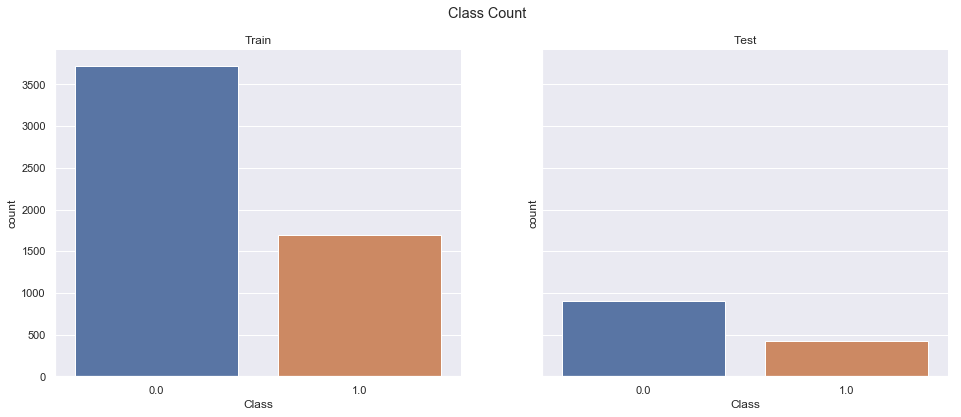

In [71]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,6), sharey=True)
plt.suptitle("Class Count")
sns.countplot(y_train, ax=ax1)
sns.countplot(y_test, ax=ax2)
ax1.set_title("Train")
ax2.set_title("Test")
ax1.set_xlabel("Class")
ax2.set_xlabel("Class")
sns.despine()

## 2. Baseline Modeling

Eventhough, the data is unbalanced. I decided not to undersample or oversample it. It important to corretly guess a restaurant that is likely to be closed. Wrongly predicting that a well-doing restaurant is going to be closed is a lost business opportunity.

For a PR curve, a good classifer aims for the upper right corner of the chart but upper left for the ROC curve.

In [73]:
# these are the first 4 features
dense_test_sel_sorted.columns.drop("is_closed")

Index(['stars_x', 'review_count', 'nearest_average_rating',
       'nearest_average_num_of_reviews'],
      dtype='object')

In [77]:
# these are the next 789 features(showing the first 10)
test_vectorizer.get_feature_names()[:10]

['able',
 'absolutely',
 'actually',
 'add',
 'added',
 'ago',
 'amazing',
 'ambiance',
 'american',
 'appetizer']

In [79]:
# combine the features
all_the_features =  list(dense_test_sel_sorted.columns.drop("is_closed")) + test_vectorizer.get_feature_names()

In [80]:
from sklearn.metrics import classification_report, confusion_matrix,roc_auc_score,average_precision_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

In [81]:
def model_statistics(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('\n Confusion Matrix')
    print(pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted']))
    print(classification_report(y_test, y_pred))
    print("ROC-AUC", roc_auc_score(y_test, y_pred))
    print("PR-AUC-Score", average_precision_score(y_test, y_pred))

    return model

In [82]:
model_A= model_statistics(LogisticRegression())


 Confusion Matrix
Predicted  0.0  1.0
True               
0.0        797  104
1.0        213  209
              precision    recall  f1-score   support

         0.0       0.79      0.88      0.83       901
         1.0       0.67      0.50      0.57       422

   micro avg       0.76      0.76      0.76      1323
   macro avg       0.73      0.69      0.70      1323
weighted avg       0.75      0.76      0.75      1323

ROC-AUC 0.6899166802552194
PR-AUC-Score 0.4916989422441498


### Health Inspection Data

In [171]:
restaurant_inspection = pd.read_csv("../../../Data & Script/nevada_restaurant_inspection.csv").drop(["State", "Serial Number", "Employee ID", "Permit Number", "Inspection Time"], axis=1)

In [172]:
restaurant_inspection.head(3)

,Restaurant Name,Location Name,Category Name,Address,City,Zip,Current Demerits,Current Grade,Date Current,Inspection Date,Inspection Type,Inspection Demerits,Inspection Grade,Permit Status,Inspection Result,Violations,Record Updated,Location 1
0,B & B RISTORANTE GARDE MANGER,B & B RISTORANTE @ VENETIAN,Garde Manger,3355 S Las Vegas Blvd,Las Vegas,89109-8941,0,A,1/26/2018 0:00,1/26/2018 0:00,Routine Inspection,0,A,A,'A' Grade,2928,1/26/2018 12:04,"(36.1214517, 115.1696112)"
1,7-Eleven #32224 - SNACK BAR,7-Eleven Convenience Store #32224,Snack Bar,5576 Boulder Hwy,Las Vegas,89122-6010,3,A,2/9/2017 0:00,2/9/2017 0:00,Routine Inspection,3,A,A,'A' Grade,"2,152,927",2/9/2017 10:37,"(36.101164, 115.0522322)"
2,BIGG MAXX'S DOGGS MOBILE,BIGG MAXX'S DOGGS MOBILE,Food Trucks / Mobile Vendor,2025 E SAHARA Ave,Las Vegas,89104,0,A,10/29/2018 0:00,10/29/2018 0:00,Routine Inspection,0,A,NaN,'A' Grade,NaN,10/29/2018 15:25,"(36.1435717, 115.1247266)"


In [173]:
restaurant_inspection.columns

Index(['Restaurant Name', 'Location Name', 'Category Name', 'Address', 'City',
       'Zip', 'Current Demerits', 'Current Grade', 'Date Current',
       'Inspection Date', 'Inspection Type', 'Inspection Demerits',
       'Inspection Grade', 'Permit Status', 'Inspection Result', 'Violations',
       'Record Updated', 'Location 1'],
      dtype='object')

In [174]:
from ast import literal_eval as make_tuple
#make_tuple("(1,2,3,4,5)") will give (1,2,3,4,5)
# change "(33,44)" to (33,44) then do the split
restaurant_inspection[['latitude', 'longitude']] = restaurant_inspection['Location 1'].apply(lambda x: make_tuple(x)).apply(pd.Series)

In [175]:
restaurant_inspection[['latitude', 'longitude']].head()

,latitude,longitude
0,36.121452,115.169611
1,36.101164,115.052232
2,36.143572,115.124727
3,36.167834,115.156188
4,36.094208,115.173065


In [176]:
restaurant_inspection = restaurant_inspection.drop("Location 1", axis=1)
restaurant_inspection.head()

,Restaurant Name,Location Name,Category Name,Address,City,Zip,Current Demerits,Current Grade,Date Current,Inspection Date,Inspection Type,Inspection Demerits,Inspection Grade,Permit Status,Inspection Result,Violations,Record Updated,latitude,longitude
0,B & B RISTORANTE GARDE MANGER,B & B RISTORANTE @ VENETIAN,Garde Manger,3355 S Las Vegas Blvd,Las Vegas,89109-8941,0,A,1/26/2018 0:00,1/26/2018 0:00,Routine Inspection,0,A,A,'A' Grade,2928,1/26/2018 12:04,36.121452,115.169611
1,7-Eleven #32224 - SNACK BAR,7-Eleven Convenience Store #32224,Snack Bar,5576 Boulder Hwy,Las Vegas,89122-6010,3,A,2/9/2017 0:00,2/9/2017 0:00,Routine Inspection,3,A,A,'A' Grade,"2,152,927",2/9/2017 10:37,36.101164,115.052232
2,BIGG MAXX'S DOGGS MOBILE,BIGG MAXX'S DOGGS MOBILE,Food Trucks / Mobile Vendor,2025 E SAHARA Ave,Las Vegas,89104,0,A,10/29/2018 0:00,10/29/2018 0:00,Routine Inspection,0,A,NaN,'A' Grade,NaN,10/29/2018 15:25,36.143572,115.124727
3,CUT & TASTE CATERING,CUT AND TASTE,Caterer,495 S GRAND CENTRAL 2203,Las Vegas,89106,0,A,1/3/2019 0:00,1/3/2019 0:00,Re-inspection,0,A,NaN,'A' Grade,2930,1/3/2019 10:47,36.167834,115.156188
4,SLICE OF VEGAS HOT LINE,SLICE OF VEGAS @ MANDALAY BAY,Special Kitchen,3930 S LAS VEGAS Blvd 120,Las Vegas,89119,8,A,11/19/2018 0:00,11/19/2018 0:00,Routine Inspection,8,A,NaN,'A' Grade,"202,211",11/19/2018 16:05,36.094208,115.173065


In [183]:
train_data_f = dense_train_sel.sort_values(by = "business_id").reset_index(drop=True).drop(["stars_x","review_count"], axis=1)
train_data_f.head(5)

,business_id,nearest_average_rating,nearest_average_num_of_reviews,is_closed
0,--9e1ONYQuAa-CB_Rrw7Tw,3.428,439.016,0
1,--q7kSBRb0vWC8lSkXFByA,3.500,146.120,1
2,-153AjTW5luZPK4omEujWA,3.376,460.157,1
3,-1m9o3vGRA8IBPNvNqKLmA,3.360,466.594,0
4,-3zffZUHoY8bQjGfPSoBKQ,3.345,445.988,0


In [184]:
train_data_f = pd.merge(train_data_f, b, on=["business_id"]).drop(["is_open", "neighborhood", "postal_code", "categories"], axis=1 )
train_data_f.head(10)

,business_id,nearest_average_rating,nearest_average_num_of_reviews,is_closed,address,city,latitude,longitude,name,review_count,stars,state
0,--9e1ONYQuAa-CB_Rrw7Tw,3.428,439.016,0,3355 Las Vegas Blvd S,Las Vegas,36.123183,-115.169190,Delmonico Steakhouse,1546,4.0,NV
1,--q7kSBRb0vWC8lSkXFByA,3.500,146.120,1,9495 Las Vegas Blvd S,Las Vegas,36.016693,-115.173115,Double Play Sports Bar,7,4.0,NV
2,-153AjTW5luZPK4omEujWA,3.376,460.157,1,"New York New York Hotel & Casino, 3790 Las Veg...",Las Vegas,36.103001,-115.173516,Jody Maroni's Sausage Kingdom,5,3.0,NV
3,-1m9o3vGRA8IBPNvNqKLmA,3.360,466.594,0,3770 Las Vegas Blvd S,Las Vegas,36.104330,-115.175593,Bavette's Steakhouse & Bar,167,4.5,NV
4,-3zffZUHoY8bQjGfPSoBKQ,3.345,445.988,0,3600 S Las Vegas Blvd,Las Vegas,36.111990,-115.177001,Michael Mina,616,4.0,NV
5,-8R_-EkGpUhBk55K9Dd4mg,3.531,171.000,0,"4850 W Sunset Rd, Ste 115",Las Vegas,36.072510,-115.206902,Sin City Thai Restaurant,114,3.5,NV
6,-9YyInW1wapzdNZrhQJ9dg,3.261,160.972,0,3000 Paradise Rd,Las Vegas,36.136257,-115.151253,Fresh Buffet,189,2.5,NV
7,-AD5PiuJHgdUcAK-Vxao2A,3.471,126.137,0,4725 S Maryland Pkwy,Las Vegas,36.103679,-115.137785,Smashburger,290,3.5,NV
8,-ADtl9bLp8wNqYX1k3KuxA,3.346,129.288,0,"7920 W Tropical Pkwy, Ste 170",Las Vegas,36.271552,-115.267631,Ichi Ramen House,390,4.0,NV
9,-AGdGGCeTS-njB_8GkUmjQ,3.325,136.984,1,953 E Sahara Ave,Las Vegas,36.143664,-115.141891,Woo Chun Korean BBQ,8,4.0,NV


In [187]:
# remove negative sign
train_data_f["latitude"] = train_data_f['latitude'].map(abs)
train_data_f["longitude"] = train_data_f['longitude'].map(abs)

In [188]:
train_data_f["longitude"].head()

0    115.169190
1    115.173115
2    115.173516
3    115.175593
4    115.177001
Name: longitude, dtype: float64

In [189]:
len(train_data_f)

5423

In [193]:
train_and_inspection = pd.merge(train_data_f, restaurant_inspection, on=['latitude', 'longitude'])

In [194]:
train_and_inspection

,business_id,nearest_average_rating,nearest_average_num_of_reviews,is_closed,address,city,latitude,longitude,name,review_count,...,Current Grade,Date Current,Inspection Date,Inspection Type,Inspection Demerits,Inspection Grade,Permit Status,Inspection Result,Violations,Record Updated
0,--q7kSBRb0vWC8lSkXFByA,3.500,146.120,1,9495 Las Vegas Blvd S,Las Vegas,36.016693,115.173115,Double Play Sports Bar,7,...,A,9/21/2018 0:00,9/21/2018 0:00,Routine Inspection,0,A,NaN,'A' Grade,NaN,9/21/2018 10:46
1,--q7kSBRb0vWC8lSkXFByA,3.500,146.120,1,9495 Las Vegas Blvd S,Las Vegas,36.016693,115.173115,Double Play Sports Bar,7,...,A,3/7/2017 0:00,3/7/2017 0:00,Routine Inspection,0,A,A,'A' Grade,NaN,3/7/2017 9:45
2,--q7kSBRb0vWC8lSkXFByA,3.500,146.120,1,9495 Las Vegas Blvd S,Las Vegas,36.016693,115.173115,Double Play Sports Bar,7,...,A,9/21/2018 0:00,9/21/2018 0:00,Routine Inspection,0,A,NaN,'A' Grade,NaN,9/21/2018 10:46
3,--q7kSBRb0vWC8lSkXFByA,3.500,146.120,1,9495 Las Vegas Blvd S,Las Vegas,36.016693,115.173115,Double Play Sports Bar,7,...,A,3/7/2017 0:00,3/7/2017 0:00,Routine Inspection,0,A,A,'A' Grade,NaN,3/7/2017 9:45
4,--q7kSBRb0vWC8lSkXFByA,3.500,146.120,1,9495 Las Vegas Blvd S,Las Vegas,36.016693,115.173115,Double Play Sports Bar,7,...,A,12/7/2011 0:00,3/25/2010 0:00,Routine Inspection,7,A,NaN,Compliant,"19,36,37,114",2/21/2013 22:26
5,--q7kSBRb0vWC8lSkXFByA,3.500,146.120,1,9495 Las Vegas Blvd S,Las Vegas,36.016693,115.173115,Double Play Sports Bar,7,...,A,12/7/2011 0:00,10/7/2010 0:00,Routine Inspection,7,A,NaN,Compliant,"12,30",2/21/2013 22:26
6,--q7kSBRb0vWC8lSkXFByA,3.500,146.120,1,9495 Las Vegas Blvd S,Las Vegas,36.016693,115.173115,Double Play Sports Bar,7,...,A,12/7/2011 0:00,3/4/2010 0:00,Routine Inspection,10,A,NaN,Compliant,"21,22,28,37,64",2/21/2013 22:26
7,--q7kSBRb0vWC8lSkXFByA,3.500,146.120,1,9495 Las Vegas Blvd S,Las Vegas,36.016693,115.173115,Double Play Sports Bar,7,...,A,12/7/2011 0:00,10/7/2010 0:00,Routine Inspection,17,B,NaN,'B' Downgrade,"4,20,22,27,64,113",2/21/2013 22:26
8,--q7kSBRb0vWC8lSkXFByA,3.500,146.120,1,9495 Las Vegas Blvd S,Las Vegas,36.016693,115.173115,Double Play Sports Bar,7,...,A,12/7/2011 0:00,11/8/2010 0:00,Routine Inspection,1,A,NaN,Compliant,37,2/21/2013 22:26
9,--q7kSBRb0vWC8lSkXFByA,3.500,146.120,1,9495 Las Vegas Blvd S,Las Vegas,36.016693,115.173115,Double Play Sports Bar,7,...,A,12/7/2011 0:00,12/7/2011 0:00,Routine Inspection,7,A,NaN,Compliant,"214,218,230",2/21/2013 22:26


In [195]:
train_data_f.columns

Index(['business_id', 'nearest_average_rating',
       'nearest_average_num_of_reviews', 'is_closed', 'address', 'city',
       'latitude', 'longitude', 'name', 'review_count', 'stars', 'state'],
      dtype='object')

In [196]:
restaurant_inspection.columns

Index(['Restaurant Name', 'Location Name', 'Category Name', 'Address', 'City',
       'Zip', 'Current Demerits', 'Current Grade', 'Date Current',
       'Inspection Date', 'Inspection Type', 'Inspection Demerits',
       'Inspection Grade', 'Permit Status', 'Inspection Result', 'Violations',
       'Record Updated', 'latitude', 'longitude'],
      dtype='object')

In [198]:
train_and_inspection[["Restaurant Name", "Location Name", 'name']].head(10)

,Restaurant Name,Location Name,name
0,DOTTY'S #87 BAR,DOTTY'S #87,Double Play Sports Bar
1,DOTTY'S #87 SNACK BAR,DOTTY'S #87,Double Play Sports Bar
2,DOTTY'S #87 SNACK BAR,DOTTY'S #87,Double Play Sports Bar
3,DOTTY'S #87 BAR,DOTTY'S #87,Double Play Sports Bar
4,Double Play Sports Bar,Double Play Sports Bar,Double Play Sports Bar
5,Double Play Sports Bar,Double Play Sports Bar,Double Play Sports Bar
6,Double Play Sports Bar Kitchen,Double Play Sports Bar,Double Play Sports Bar
7,Double Play Sports Bar Kitchen,Double Play Sports Bar,Double Play Sports Bar
8,Double Play Sports Bar Kitchen,Double Play Sports Bar,Double Play Sports Bar
9,Double Play Sports Bar Kitchen,Double Play Sports Bar,Double Play Sports Bar


In [200]:
len(set(train_and_inspection.business_id))

1589